# Modeling

In this notebook I will build **models to predict the student course outcome.** In previous notebook **EDA** I've performed the **exploratory analysis and built some visualizations**. At the end, the new dataset was stored as "final_data.csv" file in data folder.

## Goal of the Modeling
The main goal of the project is to be able to predict the outcome of the students in the course. I will build different algorithms of **multiclass classification models and evaluate their performance**. At the end of the notebook I will choose a model that has the **most appropriate parameters and performed the best.**

## Import Packages

Import standard libraries and necessary packages for transformation, modeling and evaluation. In addition, import user defined functions and classess.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RFC, GradientBoostingClassifier as GBC
from sklearn.cluster import KMeans
from xgboost import XGBClassifier as XGB


from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc
from sklearn.inspection import permutation_importance

# Import additional files with user-defined statistical functions
import sys
import os

module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import explore_data as ed 
import model_functions as mf
import model_history as mh

* Set notebook's visual parameters

In [2]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100

plt.style.use('seaborn-dark')
sns.set_theme('talk')

## Upload Dataset

Upload **final_data.csv** from data folder, keep **id_student** feature **as object type.**

In [3]:
df = pd.read_csv('../../data/final_data.csv', dtype={"id_student": str})

In [4]:
ed.show_info(df)

Lenght of Dataset: 20224
                            missing_values_% Data_type
module_presentation_length               0.0     int64
code_module                              0.0    object
code_presentation                        0.0    object
id_student                               0.0    object
date_registration                        0.0     int64
sum_click                                0.0     int64
gender                                   0.0    object
region                                   0.0    object
highest_education                        0.0    object
imd_band                                 0.0    object
age_band                                 0.0    object
num_of_prev_attempts                     0.0     int64
studied_credits                          0.0     int64
disability                               0.0    object
final_result                             0.0    object
mean_score                               0.0   float64


* I will **drop** columns that are not relevant to modeling, such that **id_student and code_presentation**.

In [5]:
df.drop(columns = ['id_student', 'code_presentation'], inplace = True)

In [6]:
df.rename(columns = {'module_presentation_length': 'course_length', 
                     'num_of_prev_attempts': 'attempts'}, inplace = True)
df.head()

,course_length,code_module,date_registration,sum_click,gender,region,highest_education,imd_band,age_band,attempts,studied_credits,disability,final_result,mean_score
0,262,DDD,88,458,M,North Western Region,Lower Than A Level,0-10%,0-35,0,60,N,Pass,86.50
1,262,DDD,136,1107,M,Scotland,HE Qualification,80-90%,55<=,0,60,N,Pass,80.00
2,262,DDD,107,663,M,West Midlands Region,A Level or Equivalent,90-100%,0-35,0,60,N,Pass,86.00
3,262,DDD,99,729,M,East Anglian Region,A Level or Equivalent,80-90%,0-35,0,90,N,Fail,65.25
4,262,DDD,143,453,F,South Region,A Level or Equivalent,40-50%,0-35,0,60,Y,Pass,87.50


## Features

* **course_length:** length of the code_module in days.
* **code_module:** three letter id of the course.
* **date_registration:** number of days student registered before the course beginning.
* **sum_click:** sum of click student made on Vle for given course.
* **gender:** gender of the student.
* **region:** region of student location in UK.
* **highest_education:** education level of the student.
* **imd_band:** indices of multiple deprivation - a measure of economic status.
* **age_band:** age category of the student.
* **attempts:** number of times the student has attempted the class.
* **disability:** disability status of the student.
* **studied credits:** number of credits student acquired by the begginning of the course.
* **mean_score:** The student's mean assessment score.


### Binarize Classes

* For the purpose of modeling, I will binarize the target labels, such that Fail/Withdraw - 1, and Pass/Distinc - 0.

In [7]:
df['final_result'] = df['final_result'].apply(lambda x: 0 if ('Pass' in x or 'Distinct' in x ) else 1)
df['final_result'].value_counts()

0    14628
1     5596
Name: final_result, dtype: int64

* Classes are imbalanced.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20224 entries, 0 to 20223
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   course_length      20224 non-null  int64  
 1   code_module        20224 non-null  object 
 2   date_registration  20224 non-null  int64  
 3   sum_click          20224 non-null  int64  
 4   gender             20224 non-null  object 
 5   region             20224 non-null  object 
 6   highest_education  20224 non-null  object 
 7   imd_band           20224 non-null  object 
 8   age_band           20224 non-null  object 
 9   attempts           20224 non-null  int64  
 10  studied_credits    20224 non-null  int64  
 11  disability         20224 non-null  object 
 12  final_result       20224 non-null  int64  
 13  mean_score         20224 non-null  float64
dtypes: float64(1), int64(6), object(7)
memory usage: 2.2+ MB


## Feature Correlation

Explore how correlated numeric features are.

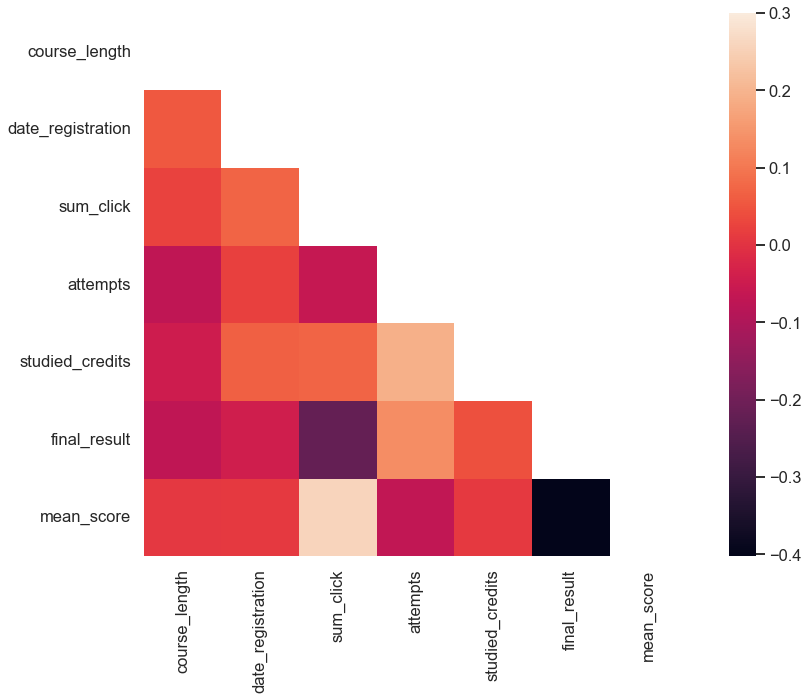

In [9]:
corr = df.corr(method = 'pearson')

mask = np.triu(np.ones_like(corr, dtype='bool'))

with sns.axes_style("white"):
    f,ax = plt.subplots(figsize = (15,10))
    ax = sns.heatmap(corr, mask = mask, vmax = 0.3, square = True)

In [10]:
corr_matrix = df.corr()
corr_mat = corr_matrix["final_result"].sort_values(ascending=False)
print(corr_mat)

final_result         1.000000
attempts             0.132633
studied_credits      0.044604
date_registration   -0.042975
course_length       -0.072593
sum_click           -0.220464
mean_score          -0.402654
Name: final_result, dtype: float64


### Train-Test Split

To prevent models from **overfitting** and to be able to **accurately evaluate model** I will split the data to **X as a features and y as a target variable, and split data into three sets: train, test and holdout.**

In [11]:
X = df.drop("final_result", axis=1)
y = df['final_result']

Now, split the data to **train and holdout sets** and then **split the train set into test and train sets too.**

In [12]:
x_all, x_hold, y_all, y_hold = train_test_split(X, y, train_size = 0.80, random_state=2021)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, train_size = 0.75,random_state=2021)

### Data Imbalance

I will check how balanced my train data is based on target feature

In [13]:
pd.Series(y_train).value_counts(normalize=True)

0    0.720949
1    0.279051
Name: final_result, dtype: float64

* It is clear that train set is imbalanced. I will build first model with this data and later on try to balance it using SMOTE.

## Baseline Model - Logistic Regression

### ColumnTransformer for Categorical Features

Before I start any modeling, I will use **ColumnTransformer and OneHotEncode** all categorical features of the dataframe:

In [14]:
cat_cols = x_train.select_dtypes(include='object').columns
indices = []
for col in cat_cols:
    indices.append(x_train.columns.get_loc(col))
indices

[1, 4, 5, 6, 7, 8, 11]

In [15]:
transformer = ColumnTransformer(transformers=[('categorical', 
                                               OneHotEncoder(handle_unknown = 'ignore'), indices)], 
                                remainder = 'passthrough')

### Build Logistic Regression Pipeline

* The pipeline will apply following transformers: ColumnTransformer, StandardScaler.

In [16]:
base_model_pipe = make_pipeline(transformer, StandardScaler(with_mean = False), 
                               LR(C=0.01, random_state=2021, max_iter = 5000))

base_model_pipe.fit(x_train, y_train)
base_model_pipe.score(x_test, y_test)

history = mh.ModelHistory()

In [17]:
history.report(base_model_pipe,x_train, y_train, 'Logistic Regression', 
               'Regression with All Features and Imbalanced Data')

Average Accuracy Score: 0.7804530409851539
Average Recall Score: 0.3983748088897073
Average Precision Score: 0.6819532673637891
Average F1 Score: 0.5024905647920963


* **Get predictions for both train and test splits.**

In [18]:
train_preds = base_model_pipe.predict(x_train)
test_preds = base_model_pipe.predict(x_test)

* **Print out evaluation metrics by calling user defined function**

In [19]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.6864321608040201
Recall Score: 0.40342587123449497
Accuracy Score: 0.7820998846217241
F1 Score: 0.5081845238095237


Precision Score: 0.6597325408618128
Recall Score: 0.3918799646954987
Accuracy Score: 0.773053152039555
F1 Score: 0.49169435215946844




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

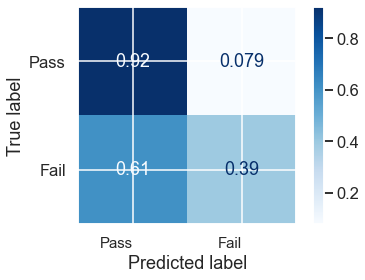

In [20]:
mf.confusion_mtx(base_model_pipe, x_test, y_test)


In [21]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     9490
False    2644
Name: final_result, dtype: int64


In [22]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     3127
False     918
Name: final_result, dtype: int64


**Model Results:**
* Model is overfitting train set. 
* From confusion matrix it is clear that model predicting most of the outcomes as "Pass", due to class imbalance
* About 1/3 of outcomes of test data were predicted falsely based on residuals

## Logistic Regression with Upsampled Data

Since the classes of the target are imbalanced, I will use **SMOTE()** in the pipeline **to upsample data.**

In [23]:
upsample_pipe = make_pipeline(transformer, StandardScaler(with_mean = False), 
                              SMOTE(random_state = 2021), 
                              LR(C=0.01, random_state=2021, max_iter = 5000))

upsample_pipe.fit(x_train, y_train)

history.report(upsample_pipe,x_train, y_train, 'Logistic Regression', 
               'Logistic Regression with Upsampled Data')

Average Accuracy Score: 0.733558470767672
Average Recall Score: 0.7105936715774724
Average Precision Score: 0.5163829966986826
Average F1 Score: 0.5979641622955632


* **Get predicted values for train and test splits**

In [24]:
train_preds = upsample_pipe.predict(x_train)
test_preds = upsample_pipe.predict(x_test)

* **Evaluation Metrics**

In [25]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.5222724338282763
Recall Score: 0.716774955699941
Accuracy Score: 0.7380089006098566
F1 Score: 0.6042574380679696


Precision Score: 0.5218811234487263
Recall Score: 0.705207413945278
Accuracy Score: 0.7364647713226206
F1 Score: 0.5998498498498498




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

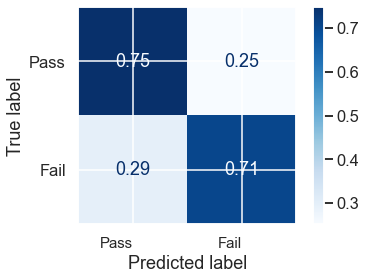

In [26]:
mf.confusion_mtx(upsample_pipe, x_test, y_test)

In [27]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     8955
False    3179
Name: final_result, dtype: int64


In [28]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2979
False    1066
Name: final_result, dtype: int64


**Model Results:**

* Upsampled model performed better than imbalanced data in terms of evaluation metrics - the recall score got higher
* The confusion matrix shows better performance in term of high diagonal values.
* The value of false negatives went down

## Grid Search for C Value

In [29]:
C = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

parameters = dict(logisticregression__C=C)

clf_GS = GridSearchCV(upsample_pipe, parameters)

clf_GS.fit(x_train, y_train)


print('Best C:', clf_GS.best_estimator_.get_params()['logisticregression__C'])

Best C: 1.0


In [30]:
lr_best_c_pipe = make_pipeline(transformer, StandardScaler(with_mean = False), SMOTE(),
                              LR(C=clf_GS.best_estimator_.get_params()['logisticregression__C'],
                                                 random_state=2021, max_iter = 5000))
lr_best_c_pipe.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [1, 4, 5, 6, 7, 8, 11])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('smote', SMOTE()),
                ('logisticregression',
                 LogisticRegression(max_iter=5000, random_state=2021))])

In [31]:
history.report(lr_best_c_pipe,x_train, y_train, 'Logistic Regression', 
               'Regression with All Features and Best C - Value')

Average Accuracy Score: 0.7342998895817008
Average Recall Score: 0.7120748437071042
Average Precision Score: 0.5172648834205739
Average F1 Score: 0.599102338064164


In [32]:
train_preds = lr_best_c_pipe.predict(x_train)
test_preds = lr_best_c_pipe.predict(x_test)

In [33]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.5219543693499785
Recall Score: 0.7161842882457177
Accuracy Score: 0.7377616614471733
F1 Score: 0.6038346613545816


Precision Score: 0.51875808538163
Recall Score: 0.707855251544572
Accuracy Score: 0.7342398022249691
F1 Score: 0.5987308697275103




<Figure size 720x720 with 0 Axes>

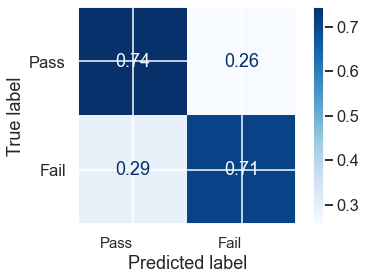

In [34]:
mf.confusion_mtx(lr_best_c_pipe, x_test, y_test)

### Model Results:
* Model Performed same as Upsampled Logistic Regression in terms of metrics
* Confusion Matrix shows higher value for false negatives

## K Nearest Neighbors

In [35]:
knn_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), KNN())

knn_pipeline.fit(x_train, y_train)
knn_pipeline.score(x_test, y_test)

0.6017305315203956

In [36]:
history.report(knn_pipeline,x_train, y_train, 'KNN - Defaults', 
               'KNN with All Features')

Average Accuracy Score: 0.6046621512418324
Average Recall Score: 0.5823326935126439
Average Precision Score: 0.36822714771717663
Average F1 Score: 0.4510728573780211


* **Get predicted values for the train and test splits**

In [37]:
train_preds = knn_pipeline.predict(x_train)
test_preds = knn_pipeline.predict(x_test)

* **Evaluation Metrics**

In [38]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.5615901455767077
Recall Score: 0.8886591848789132
Accuracy Score: 0.7753420141750453
F1 Score: 0.6882433668801463


Precision Score: 0.3696837513631407
Recall Score: 0.5984112974404237
Accuracy Score: 0.6017305315203956
F1 Score: 0.4570273003033367




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

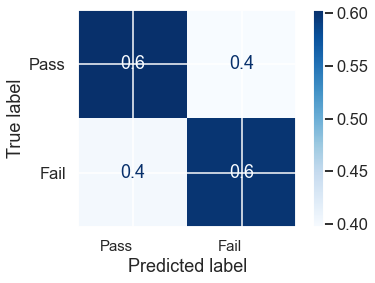

In [39]:
mf.confusion_mtx(knn_pipeline, x_test, y_test)

In [40]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     9408
False    2726
Name: final_result, dtype: int64


In [41]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2434
False    1611
Name: final_result, dtype: int64


### Model Results:
* Model is overfitting training data based on metrics
* Confusion matrix on test sets shows increased value for false negatives

## Decision Tree Model

In [42]:
dt_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), DT(random_state = 2021))

In [43]:
dt_pipeline.fit(x_train, y_train)
dt_pipeline.score(x_test, y_test)

0.7060568603213844

In [44]:
history.report(dt_pipeline,x_train, y_train, 'Decision Tree - Defaults', 
               'Decision Tree with All Features')

Average Accuracy Score: 0.705372128682817
Average Recall Score: 0.5419720967999971
Average Precision Score: 0.4756298579344211
Average F1 Score: 0.5064727067571997


* **Predicted Values**

In [45]:
train_preds = dt_pipeline.predict(x_train)
test_preds = dt_pipeline.predict(x_test)

* **Evaluation Metrics**

In [46]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 1.0
Recall Score: 1.0
Accuracy Score: 1.0
F1 Score: 1.0


Precision Score: 0.4778481012658228
Recall Score: 0.5330979699911739
Accuracy Score: 0.7060568603213844
F1 Score: 0.5039632874426366




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

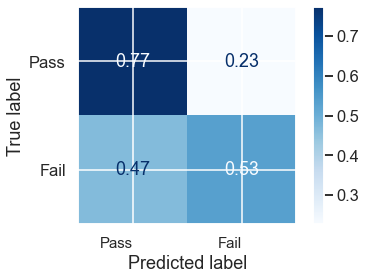

In [47]:
mf.confusion_mtx(dt_pipeline, x_test, y_test)

In [48]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True    12134
Name: final_result, dtype: int64


In [49]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2856
False    1189
Name: final_result, dtype: int64


* Model is overfitting training data

### Max Depth of Tree

I will use the AUC and ROC to identify optimal depth of the tree.

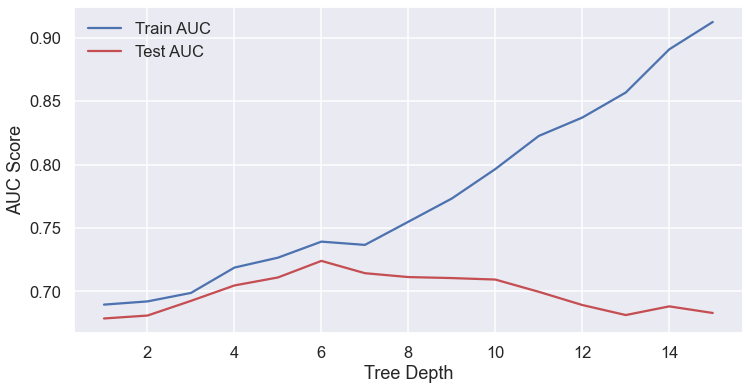

In [50]:
max_depths = np.linspace(1, 15, 15, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
    
    dt_depth_p = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), DT( max_depth=max_depth,
                                         random_state = 1))
    dt_depth_p.fit(x_train, y_train)
    train_pred = dt_depth_p.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt_depth_p.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC Score')
plt.xlabel('Tree Depth')
plt.legend()
plt.show()

In [51]:
# Max depth 5 or 7

In [52]:
dt_pipe_2 = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), DT(random_state = 2021, max_depth = 5))

In [53]:
dt_pipe_2.fit(x_train, y_train)
dt_pipe_2.score(x_test, y_test)

0.7087762669962917

In [54]:
history.report(dt_pipe_2,x_train, y_train, 'Decision Tree - Depth 5', 
               'Decision Tree with Max Depth of 5')

Average Accuracy Score: 0.7331465412452414
Average Recall Score: 0.63281717269927
Average Precision Score: 0.5187750870336272
Average F1 Score: 0.5692787580176718


* **Predicted Values**

In [55]:
train_preds = dt_pipe_2.predict(x_train)
test_preds = dt_pipe_2.predict(x_test)

* **Evaluation Metrics**

In [56]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.4976195873951485
Recall Score: 0.6482575310100414
Accuracy Score: 0.7192187242459206
F1 Score: 0.5630370655380275


Precision Score: 0.48462064251537934
Recall Score: 0.6257722859664607
Accuracy Score: 0.7087762669962917
F1 Score: 0.5462249614791987




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

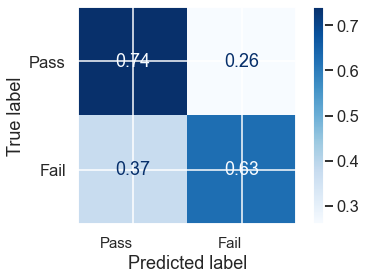

In [57]:
mf.confusion_mtx(dt_pipe_2, x_test, y_test)

In [58]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     8727
False    3407
Name: final_result, dtype: int64


In [59]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2867
False    1178
Name: final_result, dtype: int64


### Model Results:

* After tuning depth of the tree, the metrics show almost no overfitting.
* The confusion matrix show slightly better results, but still worse than Linear Regression
* The value of false negatives is high.

## Random Forest Model

I will use same depth for Random Forest Model as I used in Decision Tree

In [60]:
rf_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), RFC(max_depth = 5, random_state = 2021))

In [61]:
rf_pipeline.fit(x_train, y_train)
rf_pipeline.score(x_test, y_test)

0.734981458590853

In [62]:
history.report(rf_pipeline,x_train, y_train, 'Random Forest - Depth 5', 
               'Random Forest with All Features and Depth 5')

Average Accuracy Score: 0.7333114896148398
Average Recall Score: 0.6620979901230009
Average Precision Score: 0.5171299785675652
Average F1 Score: 0.5805604171750278


* **Predicted Values**

In [63]:
train_preds = rf_pipeline.predict(x_train)
test_preds = rf_pipeline.predict(x_test)

* **Evaluation Metrics**

In [64]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.5365853658536586
Recall Score: 0.6757235676314235
Accuracy Score: 0.7466622713037745
F1 Score: 0.5981699346405229


Precision Score: 0.5218951902368988
Recall Score: 0.6416593115622242
Accuracy Score: 0.734981458590853
F1 Score: 0.5756136183689627




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

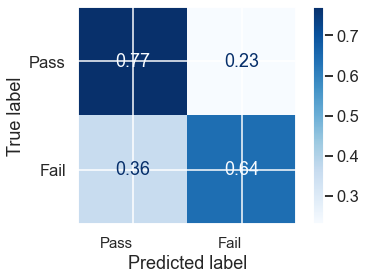

In [65]:
mf.confusion_mtx(rf_pipeline, x_test, y_test)

In [66]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     9060
False    3074
Name: final_result, dtype: int64


In [67]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2973
False    1072
Name: final_result, dtype: int64


### Model Results:

* The metrics show infignificant improvement compared to Decision Tree
* Confusion Matrix has slightly worse values than Decision Tree 

## Gradient Boost

In [68]:
gbc_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), GBC(max_depth = 5, random_state = 2021))

In [69]:
gbc_pipeline.fit(x_train, y_train)
gbc_pipeline.score(x_test, y_test)

0.7839307787391842

In [70]:
history.report(gbc_pipeline,x_train, y_train, 'Gradient Boost - Depth 5', 
               'Gradient Boost with All Features and Depth 5')

Average Accuracy Score: 0.7917423953301073
Average Recall Score: 0.5808659920569121
Average Precision Score: 0.6391683167552218
Average F1 Score: 0.6085307646656949


* **Predicted Values**

In [71]:
train_preds = gbc_pipeline.predict(x_train)
test_preds = gbc_pipeline.predict(x_test)

* **Evaluation Metrics**

In [72]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.7171484888304862
Recall Score: 0.6447135262847017
Accuracy Score: 0.8298994560738421
F1 Score: 0.67900466562986


Precision Score: 0.6275862068965518
Recall Score: 0.5622241835834069
Accuracy Score: 0.7839307787391842
F1 Score: 0.5931098696461825




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

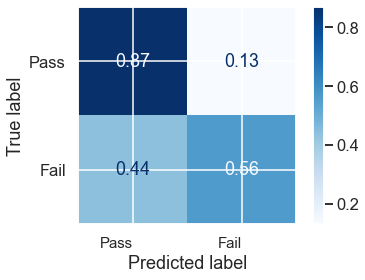

In [73]:
mf.confusion_mtx(gbc_pipeline, x_test, y_test)

In [74]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     10070
False     2064
Name: final_result, dtype: int64


In [75]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     3171
False     874
Name: final_result, dtype: int64


### Model Results:

* Evaluation metrics show that model is overfitting training set
* Confusion matrix has worse results compared to models above

## XGBoost



In [76]:
xgb_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), XGB(use_label_encoder=False, verbosity=0))

In [77]:
xgb_pipeline.fit(x_train, y_train)
xgb_pipeline.score(x_test, y_test)

0.7812113720642769

In [78]:
history.report(xgb_pipeline,x_train, y_train, 'XGBoost - Defaults', 
               'XGBoost with All Features')

Average Accuracy Score: 0.7910828734834461
Average Recall Score: 0.5243773623686172
Average Precision Score: 0.6568545143853204
Average F1 Score: 0.5830663296579316


* **Predicted Values**

In [79]:
train_preds = xgb_pipeline.predict(x_train)
test_preds = xgb_pipeline.predict(x_test)

* **Evaluation Metrics**

In [80]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.8269372693726937
Recall Score: 0.6618428824571766
Accuracy Score: 0.8669853304763474
F1 Score: 0.735236220472441


Precision Score: 0.6330472103004292
Recall Score: 0.5207413945278023
Accuracy Score: 0.7812113720642769
F1 Score: 0.5714285714285715




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

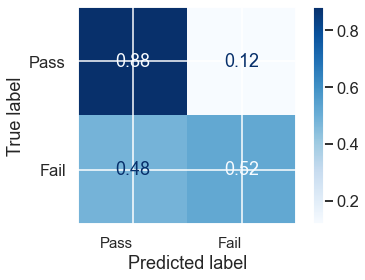

In [81]:
mf.confusion_mtx(xgb_pipeline, x_test, y_test)

In [82]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     10520
False     1614
Name: final_result, dtype: int64


In [83]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     3160
False     885
Name: final_result, dtype: int64


### Model Results:

* Almost the same metric results as for Gradient Boost - overfitting training set
* Worse values for confusion matrix

## Feature Importance Logistic Regression

In [84]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12134 entries, 1739 to 5312
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   course_length      12134 non-null  int64  
 1   code_module        12134 non-null  object 
 2   date_registration  12134 non-null  int64  
 3   sum_click          12134 non-null  int64  
 4   gender             12134 non-null  object 
 5   region             12134 non-null  object 
 6   highest_education  12134 non-null  object 
 7   imd_band           12134 non-null  object 
 8   age_band           12134 non-null  object 
 9   attempts           12134 non-null  int64  
 10  studied_credits    12134 non-null  int64  
 11  disability         12134 non-null  object 
 12  mean_score         12134 non-null  float64
dtypes: float64(1), int64(5), object(7)
memory usage: 1.3+ MB


In [85]:
num_vars = ['course_length', 'date_registration', 'sum_click', 'attempts', 'studied_credits', 'mean_score']

cat_vars = upsample_pipe.named_steps['columntransformer'].transformers_[0][1].get_feature_names().tolist()

features_df = list(zip(num_vars + cat_vars, upsample_pipe.named_steps['logisticregression'].coef_[0]))

In [86]:
feature_importance = pd.DataFrame(features_df, columns = ["feature", "importance"])
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)

<BarContainer object of 48 artists>

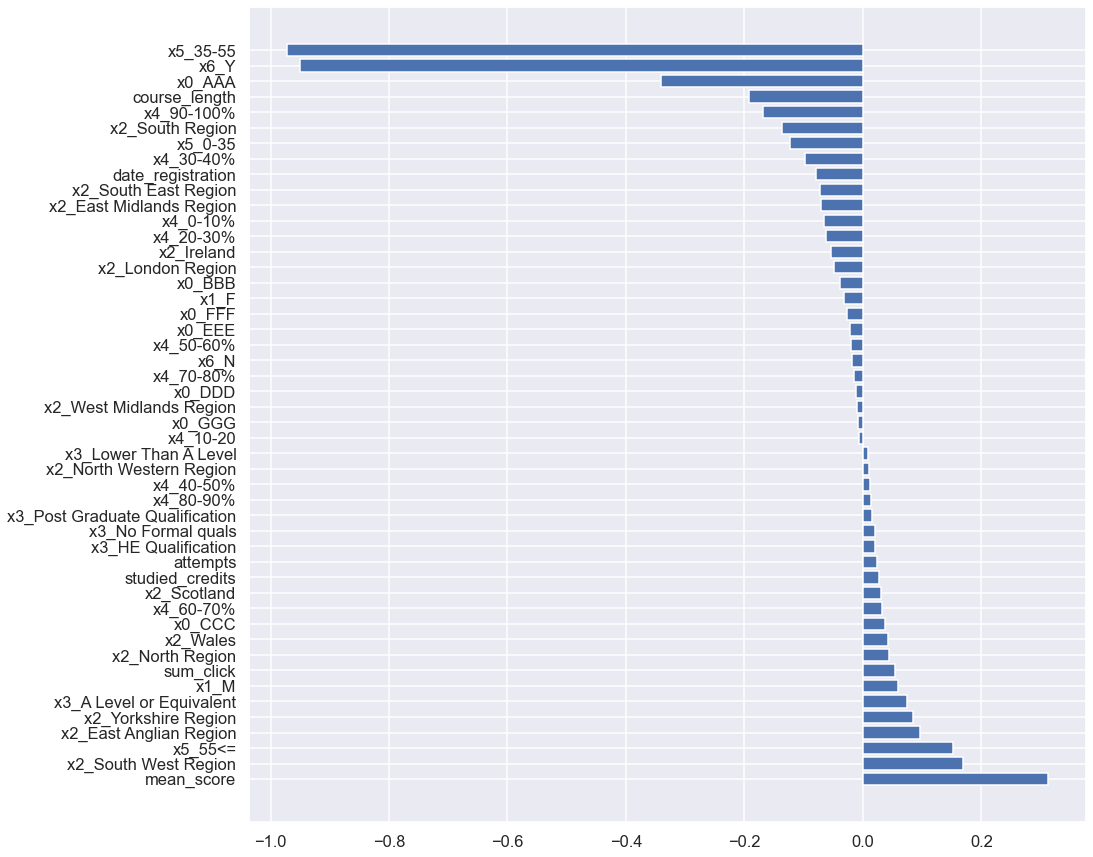

In [87]:
fig, ax = plt.subplots(figsize = (15,15))
ax.barh(width=feature_importance.importance, y=feature_importance.feature)

In [88]:
imp_features = feature_importance[(feature_importance['importance'] > 0)]
imp_features = imp_features['feature'].tolist()

## Random Forest Feature Importance

In [89]:
rf_permutation = permutation_importance(rf_pipeline, x_train, y_train)

In [90]:
rf_features = list(zip(x_train.columns, rf_permutation['importances_mean']))

In [91]:
rf_feature_importance = pd.DataFrame(rf_features, columns = ["feature", "importance"])

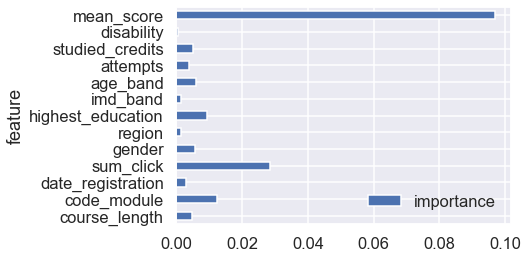

In [92]:
ax = rf_feature_importance.plot.barh(x='feature', y='importance')
plt.show()

# fig, ax = plt.subplots(figsize = (15,15))
# ax.barh(width=rf_feature_importance.importance, y=rf_feature_importance.feature)

## GridSearch for Best Model Parameters

In [93]:
models = {LR: {'C': [0.01, 0.02, 0.03, 0.05, 0.1, 0,2, 0.3, 0.5],
               'max_iter': [50, 100, 200, 500],
               'penalty': ['l2', 'l1', 'elasticnet', None],
               'solver': ['newton-cg', 'lbfgs', 'saga'], 
               'random_state': [2021]},
          KNN: {'metric': ['euclidean', 'manhattan'],
                'n_neighbors': [2, 3, 4, 5, 7, 10, 15],
                'weights': ['uniform', 'distance']},
          DT: {'criterion': ['gini', 'entropy'],
               'max_depth': [None, 4, 5, 7, 10],
               'min_samples_split': [2, 3, 5, 10],
               'random_state': [2021]}}
          

In [94]:
tuned_models = {}

for model, params in models.items():
    pipe = make_pipeline(transformer, StandardScaler(with_mean = False),
                         SMOTE(),model())
    
    model_name = model.__name__.lower()
    parameters = dict(map(lambda x: (model_name +'__'+x[0], x[1]), params.items()))
    
    grid = GridSearchCV(pipe, parameters)
    grid.fit(x_train, y_train)
    tuned_models[model_name] = grid.best_estimator_.get_params()

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", 

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/capstone/lib/pyt

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/capstone/lib/pyt

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/capstone/lib/pyt

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/capstone/lib/pyt

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/capstone/lib/pyt

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/capstone/lib/pyt

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/capstone/lib/pyt

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/capstone/lib/pyt

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/capstone/lib/pyt

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/capstone/lib/pyt

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/capstone/lib/pyt

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/capstone/lib/pyt

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/capstone/lib/pyt

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/capstone/lib/pyt

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/capstone/lib/pyt

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/capstone/lib/pyt

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/capstone/lib/pyt

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/capstone/lib/pyt

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/capstone/lib/pyt

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/capstone/lib/pyt

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_mode

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties,

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s

In [95]:
tuned_models

{'logisticregression': {'memory': None,
  'steps': [('columntransformer',
    ColumnTransformer(remainder='passthrough',
                      transformers=[('categorical',
                                     OneHotEncoder(handle_unknown='ignore'),
                                     [1, 4, 5, 6, 7, 8, 11])])),
   ('standardscaler', StandardScaler(with_mean=False)),
   ('smote', SMOTE()),
   ('logisticregression',
    LogisticRegression(C=0.1, max_iter=500, random_state=2021, solver='saga'))],
  'verbose': False,
  'columntransformer': ColumnTransformer(remainder='passthrough',
                    transformers=[('categorical',
                                   OneHotEncoder(handle_unknown='ignore'),
                                   [1, 4, 5, 6, 7, 8, 11])]),
  'standardscaler': StandardScaler(with_mean=False),
  'smote': SMOTE(),
  'logisticregression': LogisticRegression(C=0.1, max_iter=500, random_state=2021, solver='saga'),
  'columntransformer__n_jobs': None,
  'columntransfor

## Logistic Regression with Best Parameters

In [97]:
lr_best_pipe = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), LR(C=0.1, max_iter=500, random_state=2021, solver='saga'))

In [98]:
lr_best_pipe.fit(x_train, y_train)
lr_best_pipe.score(x_test, y_test)

0.7354758961681088

In [99]:
history.report(lr_best_pipe,x_train, y_train, 'Logistic Regression - Best Params', 
               'Logistic Regression with GridSearched Parameters')

Average Accuracy Score: 0.7344649737671656
Average Recall Score: 0.7123062998035309
Average Precision Score: 0.5174827240870461
Average F1 Score: 0.5993321156754452


* **Predicted Values**

In [100]:
train_preds = lr_best_pipe.predict(x_train)
test_preds = lr_best_pipe.predict(x_test)

* **Evaluation Metrics**

In [101]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.5213565142734492
Recall Score: 0.7173656231541642
Accuracy Score: 0.7373495961760342
F1 Score: 0.6038533250466127


Precision Score: 0.5203883495145631
Recall Score: 0.7096204766107679
Accuracy Score: 0.7354758961681088
F1 Score: 0.6004480955937267




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

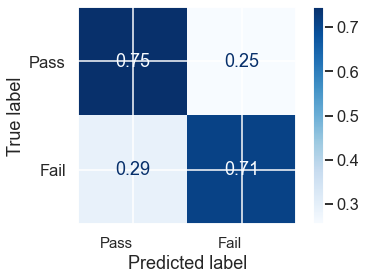

In [102]:
mf.confusion_mtx(lr_best_pipe, x_test, y_test)

## KNN with Best Parameters

In [103]:
knn_best_pipe = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), KNN(metric='manhattan', n_neighbors=2))

In [104]:
knn_best_pipe.fit(x_train, y_train)
knn_best_pipe.score(x_test, y_test)

0.6929542645241038

In [105]:
history.report(knn_best_pipe,x_train, y_train, 'KNN - Best Parameters', 
               'KNN with GridSearched Parameters')

Average Accuracy Score: 0.6950728720030531
Average Recall Score: 0.2606059484941829
Average Precision Score: 0.4232835792780868
Average F1 Score: 0.32240187864826864


* **Predicted Values**

In [106]:
train_preds = knn_best_pipe.predict(x_train)
test_preds = knn_best_pipe.predict(x_test)

* **Evaluation Metrics**

In [107]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 1.0
Recall Score: 0.8044890726520969
Accuracy Score: 0.9454425581012033
F1 Score: 0.8916530278232405


Precision Score: 0.4211287988422576
Recall Score: 0.25684024713150927
Accuracy Score: 0.6929542645241038
F1 Score: 0.3190789473684211




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

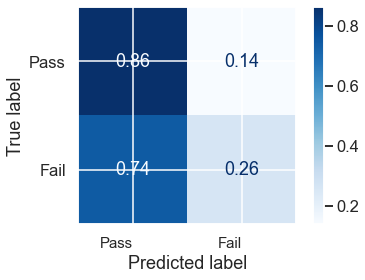

In [108]:
mf.confusion_mtx(knn_best_pipe, x_test, y_test)

## Decision Tree with Best Parameters

In [109]:
dt_best_pipe = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), DT(max_depth=7, min_samples_split=10, random_state=2021))

In [110]:
dt_best_pipe.fit(x_train, y_train)
dt_best_pipe.score(x_test, y_test)

0.7396786155747836

In [111]:
history.report(dt_best_pipe,x_train, y_train, 'DT - Best Parameters', 
               'DT with GridSearched Parameters')

Average Accuracy Score: 0.746579137868044
Average Recall Score: 0.6494123133930467
Average Precision Score: 0.5382662284733425
Average F1 Score: 0.5883895654783698


* **Predicted Values**

In [112]:
train_preds = dt_best_pipe.predict(x_train)
test_preds = dt_best_pipe.predict(x_test)

* **Evaluation Metrics**

In [113]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.5614860098753821
Recall Score: 0.7052569403425871
Accuracy Score: 0.7640514257458382
F1 Score: 0.6252127241785574


Precision Score: 0.527816411682893
Recall Score: 0.6699029126213593
Accuracy Score: 0.7396786155747836
F1 Score: 0.5904317386231039




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

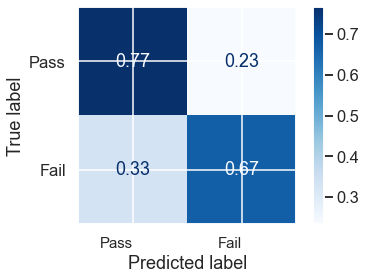

In [114]:
mf.confusion_mtx(dt_best_pipe, x_test, y_test)

### Results:

* Logistic Regression showed best results with grid serached parameters.
* The KNN and Decision Tree are overfitting training data

## Recursive Feature Selection for LR

In [115]:
from sklearn.feature_selection import RFE

In [116]:
lr_pipe_imp = make_pipeline(transformer, StandardScaler(with_mean = False), 
                            SMOTE(), RFE(estimator=LR(C=0.01, random_state=2021, max_iter = 5000), 
                                         n_features_to_select=22),
                            LR(C=0.01, random_state=2021, max_iter = 5000))

In [117]:
lr_pipe_imp.fit(x_train, y_train)

history.report(lr_pipe_imp,x_train, y_train, 'Linear Regression RFE Features', 
               'Linear Regression with RFE Features')

Average Accuracy Score: 0.7329817286915092
Average Recall Score: 0.7083020467158813
Average Precision Score: 0.515556102130425
Average F1 Score: 0.5966408250397972


In [118]:
train_preds = lr_pipe_imp.predict(x_train)
test_preds = lr_pipe_imp.predict(x_test)

In [119]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.5208243881494203
Recall Score: 0.7164796219728293
Accuracy Score: 0.7369375309048953
F1 Score: 0.6031824962705122


Precision Score: 0.5203883495145631
Recall Score: 0.7096204766107679
Accuracy Score: 0.7354758961681088
F1 Score: 0.6004480955937267




<Figure size 720x720 with 0 Axes>

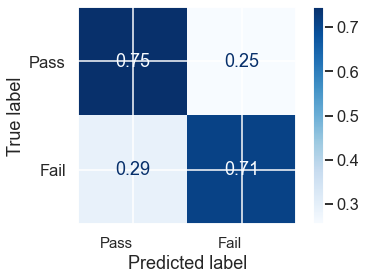

In [120]:
mf.confusion_mtx(lr_pipe_imp, x_test, y_test)

In [121]:
history.history

,Name,Accuracy_Score,Recall_Score,Precision_Score,F1_Score,Notes
0,KNN - Best Parameters,0.695073,0.260606,0.423284,0.322402,KNN with GridSearched Parameters
1,Logistic Regression,0.780453,0.398375,0.681953,0.502491,Regression with All Features and Imbalanced Data
2,XGBoost - Defaults,0.791083,0.524377,0.656855,0.583066,XGBoost with All Features
3,Decision Tree - Defaults,0.705372,0.541972,0.475630,0.506473,Decision Tree with All Features
4,Gradient Boost - Depth 5,0.791742,0.580866,0.639168,0.608531,Gradient Boost with All Features and Depth 5
5,KNN - Defaults,0.604662,0.582333,0.368227,0.451073,KNN with All Features
6,Decision Tree - Depth 5,0.733147,0.632817,0.518775,0.569279,Decision Tree with Max Depth of 5
7,DT - Best Parameters,0.746579,0.649412,0.538266,0.588390,DT with GridSearched Parameters
8,Random Forest - Depth 5,0.733311,0.662098,0.517130,0.580560,Random Forest with All Features and Depth 5
12,Linear Regression RFE Features,0.732982,0.708302,0.515556,0.596641,Linear Regression with RFE Features


# Modeling Results

Based on the **Recall and F1** Scores, the **Logistic Regression Model** with Grid Searched parameters has performed the best - **Recall(0.71), F1(0.59).** The **confusion matrix** shows **lowest values for false negative** predictions - predicting pass, while student is failing. I will **test the model on holdout data.** 

## Predicting on Holdout Data

In [122]:
train_preds = lr_best_pipe.predict(x_train)
hold_preds = lr_best_pipe.predict(x_hold)

In [123]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_hold,hold_preds)

Precision Score: 0.5213565142734492
Recall Score: 0.7173656231541642
Accuracy Score: 0.7373495961760342
F1 Score: 0.6038533250466127


Precision Score: 0.5086042065009561
Recall Score: 0.7409470752089137
Accuracy Score: 0.7404202719406675
F1 Score: 0.6031746031746033




<Figure size 720x720 with 0 Axes>

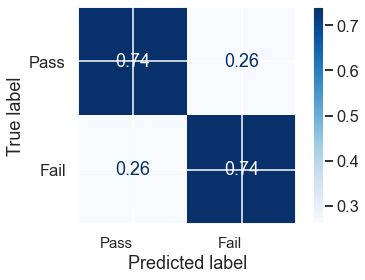

In [124]:
mf.confusion_mtx(lr_best_pipe, x_hold, y_hold)


### Results:

* Model showed better performance on holdout data than on test data. The value for false negatives on hold data is 0.26 based on confusion matrix.
* The recall score of 0.74 indicates that 74% of the results were predicted truly as Fail, and 0.78 precision indicates that 78% of final results were correctly predicted as Pass.

<Figure size 720x720 with 0 Axes>

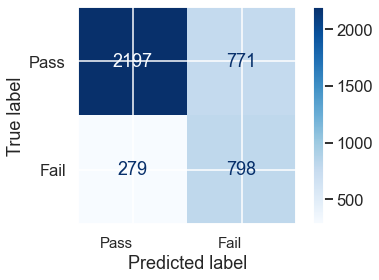

In [125]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(lr_best_pipe, x_hold, y_hold,
                     cmap=plt.cm.Blues, display_labels=
                          ['Pass', 'Fail'])

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()